In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
from brukeropusreader import read_file
from scipy.interpolate import interp1d


In [2]:
# Define folder paths
folder_path_oe = 'Spectra RE'
folder_path_re = 'Spectra OE'
folder_path_trachea = 'Spectra TR'

# Function to list files in a folder
def list_files(folder_path):
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    return files

# List files in each folder
files_re = list_files(folder_path_re)
files_oe = list_files(folder_path_oe)
files_tr = list_files(folder_path_trachea)

# Displaying file names and their count
print("RE Folder:")
print(f"Number of files: {len(files_re)}")
print("Files:", files_re)

# Define the common set of wavenumbers
start_wavenumber = 5000  # Starting wavenumber
end_wavenumber = 400  # Ending wavenumber
resolution = 1  # Resolution in cm⁻¹

# Generate the common set of wavenumbers
common_wavenumbers = np.arange(start_wavenumber, end_wavenumber - resolution, -resolution)

# Verify the first and last values as well as the size of the set to ensure it matches expectations
print("First wavenumber:", common_wavenumbers[0])
print("Last wavenumber:", common_wavenumbers[-1])
print("Total number of points:", len(common_wavenumbers))

def get_wavenumbers(file_path):
    opus_data = read_file(file_path)
    # Assuming wavenumbers are stored in a key 'WN' in the returned data
    num_points = len(opus_data['AB'])
    start_wn = opus_data['AB Data Parameter']['FXV']
    end_wn = opus_data['AB Data Parameter']['LXV']
    # Generate the list of wavenumbers
    wavenumbers = np.linspace(start_wn, end_wn, num_points)
    return wavenumbers

def get_spectral_data(file_path):
    """
    Extracts spectral data (e.g., absorbance values) from a file.

    Parameters:
    - file_path: The path to the Bruker file.

    Returns:
    - A numpy array containing the spectral data.
    """
    opus_data = read_file(file_path)
    # Assuming the spectral data is stored in the 'AB' key
    spectral_data = opus_data['AB']
    return spectral_data

def interpolate_to_common_wavenumbers(file_path, common_wavenumbers):
    """
    Interpolates the spectral data from a file to a common set of wavenumbers.
    
    Parameters:
    - file_path: The path to the file.
    - common_wavenumbers: The common wavenumbers to interpolate the data to.
    
    Returns:
    - A numpy array of the interpolated spectral data.
    """
    original_wavenumbers = get_wavenumbers(file_path)
    original_data = get_spectral_data(file_path)
    interpolation_func = interp1d(original_wavenumbers, original_data, kind='linear', fill_value="extrapolate")
    interpolated_data = interpolation_func(common_wavenumbers)
    return interpolated_data

def z_score_normalize(data):
    """
    Normalizes a data array using Z-score normalization.
    
    Parameters:
    - data: A numpy array of spectral data.
    
    Returns:
    - The Z-score normalized spectral data.
    """
    mean = np.mean(data)
    std_dev = np.std(data)
    normalized_data = (data - mean) / std_dev
    return normalized_data

def process_directory(folder_path, common_wavenumbers):
    """
    Processes all files in a directory, interpolating and normalizing their spectral data.
    
    Parameters:
    - folder_path: The path to the directory.
    - common_wavenumbers: The common wavenumbers to interpolate the data to.
    
    Returns:
    - A numpy array of all the normalized spectral data from the directory.
    """
    normalized_data_list = []
    files = list_files(folder_path)
    for file in files:
        file_path = os.path.join(folder_path, file)
        data = interpolate_to_common_wavenumbers(file_path, common_wavenumbers)
        
        # Cut the spectra to the wavenumbers from 800 to 1900 cm⁻¹
        mask = (common_wavenumbers >= 900) & (common_wavenumbers <= 1800)
        data = data[mask]
        
        normalized_data = z_score_normalize(data)
        normalized_data_list.append(normalized_data)
    return np.array(normalized_data_list)


RE Folder:
Number of files: 210
Files: ['20240408 A5 OE.0004', '20240408 A5 OE.0003', '20240408 A2 OE.0001', '15012024 OE 4.0000', '15012024 OE 3.0012', '20240311 OE 1.0003', '19022024 OE 4.0004', '05022024 OE 1 mit max druck.0004', '20240415 B5 OE.0002', '20240415 B2 OE.0000', '20240311 OE 1.0004', '05022024 OE 1 mit max druck.0003', '20240318 OE A2.0000', '20240311 OE 5.0001', '19022024 OE 4.0003', '20240304 OE 3.0000', '15012024 OE 3.0013', '15012024 OE 4.0001', '15012024 OE 3.0014', '20240408 A5 OE.0002', '20240408 A2 OE.0000', '20240304 OE 3.0001', '20240311 OE 5.0000', '19022024 OE 4.0002', '20240318 OE A2.0001', '05022024 OE 1 mit max druck.0002', '20240415 B5 OE.0004', '20240311 OE 1.0002', '20240415 B5 OE.0003', '20240415 B2 OE.0001', '19022024 OE 1.0000', '19022024 OE 5.0002', '20240318 OE A3.0001', '05022024 OE 2 mit max druck.0002', '05022024 OE 5 mit max druck.0000', '20240408 A3 OE.0000', '20240408 A4 OE.0002', '20240304 OE 2.0001', '15012024 OE 1.0004', '15012024 OE 5.00

              precision    recall  f1-score   support

          OE       0.76      0.74      0.75        47
          RE       0.67      0.70      0.68        37
     Trachea       1.00      0.96      0.98        27

    accuracy                           0.78       111
   macro avg       0.81      0.80      0.81       111
weighted avg       0.79      0.78      0.79       111

[[35 12  0]
 [11 26  0]
 [ 0  1 26]]


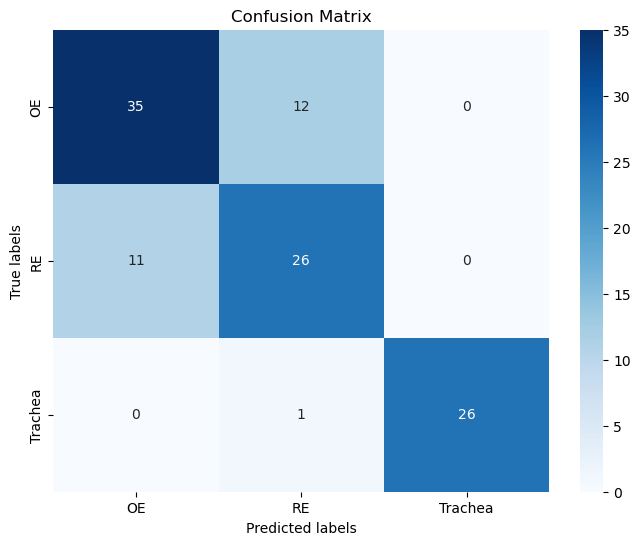

Cross-validation scores: [0.78378378 0.74774775 0.72972973 0.68468468 0.75675676]
Average score: 0.74
Standard deviation of scores: 0.03


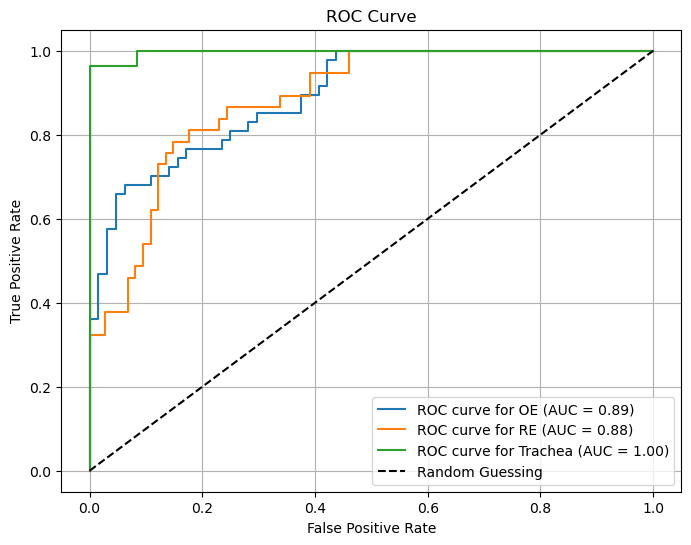

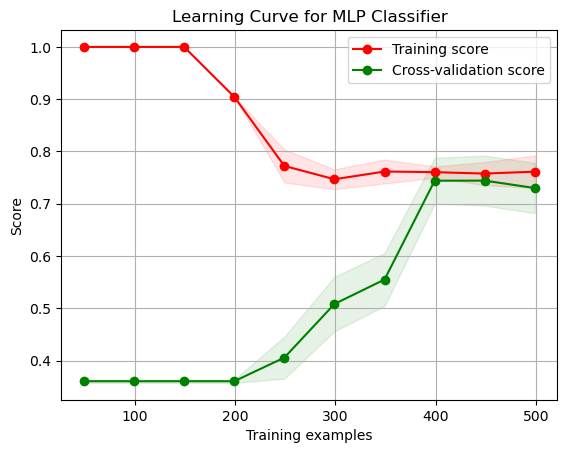

In [3]:
# Process directories
data_oe = process_directory(folder_path_oe, common_wavenumbers)
data_re = process_directory(folder_path_re, common_wavenumbers)
data_trachea = process_directory(folder_path_trachea, common_wavenumbers)

# Combine the average spectral data into one dataset and create labels
X = np.vstack([data_oe, data_re, data_trachea])
y = np.array([0] * len(data_oe) + [1] * len(data_re) + [2] * len(data_trachea))

# Split the data into a temporary training dataset and final test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the temporary training dataset into actual training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Model training
# Initialize the MLP model
model = MLPClassifier(max_iter=500, random_state=42)
model.fit(X_train, y_train)

# Train the model with the training data
model.fit(X_train, y_train)

# Evaluate the model
class_names = ['OE', 'RE', 'Trachea']

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=class_names))
print(confusion_matrix(y_test, y_pred))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create the heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Perform 10-fold cross-validation
scores = cross_val_score(model, X, y, cv=5)

# Calculate the average and standard deviation of the scores, rounded to 2 decimal places
average_score = np.mean(scores)
std_deviation = np.std(scores)

# Print the results, rounded to 2 decimal places
print("Cross-validation scores:", scores)
print("Average score:", f"{average_score:.2f}")
print("Standard deviation of scores:", f"{std_deviation:.2f}")

# Compute and plot ROC curves
# Get the predicted probabilities for each class
y_prob = model.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
plt.figure(figsize=(8, 6))
for class_index in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_test == class_index, y_prob[:, class_index])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve for {class_names[class_index]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Function to plot learning curve
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Initialize the MLP model
model = MLPClassifier(max_iter=500, random_state=42)

# Plot learning curve for the MLP model
title = "Learning Curve for MLP Classifier"
cv = 10  # Number of folds in cross-validation
plot_learning_curve(model, title, X, y, cv=cv)
plt.show()